In [1]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as pb
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [2]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [3]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [4]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [5]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

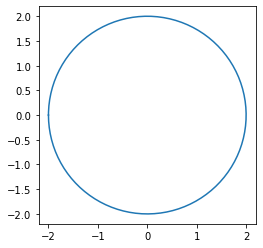

In [6]:
npoints=200
theta = np.linspace( -np.pi,np.pi, npoints)

# the radius of the circle
r = 2

# compute x1 and x2
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

# create the figure
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.set_aspect(1)
plt.show()

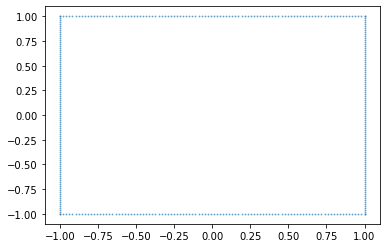

In [7]:
x=np.array([])
y=np.array([])
x=np.append(x,np.array([-1]*100))
y=np.append(y,np.linspace(-1,1,100))
x= np.append(x,np.linspace(-1,1,100))
y=np.append(y,np.array([1]*100))
x=np.append(x,np.array([1]*100))
y=np.append(y,np.linspace(1,-1,100))
x=np.append(x,np.linspace(1,-1,100))
y=np.append(y,np.array([-1]*100))

plt.figure()
plt.scatter(x,y,s=1,alpha=0.5)

In [8]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory1(t):
    theta = np.linspace( -np.pi,np.pi, npoints)

    # the radius of the circle
    r = t

    # compute x1 and x2
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    for i in range(npoints):
        for j in range(1):
            control(np.array([x1[i],x2[i]]))
    

    
    
    



In [9]:
def trajectory2():
    for i in range(400):
        for j in range(1):
            control(np.array([x[i],y[i]]))

In [10]:
pos_actual=[]

In [11]:
##########################################
# Control loop to follow the trajectory
##########################################
# Kinematics for serial-2R
def control(numpy_array):
    pt_des = numpy_array # or p2

    valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)
    if valid==False:
        return
    
    
    dt     = 0.0001 # simulation time-step
    p_gain = 2000 # Proportional gain
    d_gain = 10 # Derivative gain
    error  = 0
    error_old = 0
    desired_pos = np.array([theta1, theta2])
    for _ in range(1000):
        pos1, _, _, _ = pb.getJointState(scara,1)
        pos2, _, _, _ = pb.getJointState(scara,2)
        pos = np.array([pos1, pos2])
        error_old = error
        error = desired_pos - pos
        error_d = (error - error_old)/dt
        control_force = p_gain * error + d_gain * error_d
        control_force = np.clip(control_force, -500, 500)
        pb.setJointMotorControlArray(scara, [1,2], pb.TORQUE_CONTROL, forces=control_force)
        pb.stepSimulation()


    # Check if the robot has reached the desired position
    pos1, _, _, _ = pb.getJointState(scara, 1)
    pos2, _, _, _ = pb.getJointState(scara, 2)
    pt_act = forward_kinematics(pos1, pos2, 1, 1)
    pos_actual.append(pt_act)
    print(pt_des)
    print(pt_act)





In [12]:
trajectory2()

[-1. -1.]
[-0.01000750339928258, 0.14112000805988562]
[-1.         -0.97979798]
[-0.007154554741141017, 0.14129337969475023]
[-1.         -0.95959596]
[-0.004297560181187765, 0.14140911489574462]
[-1.         -0.93939394]
[-0.0014366189072834157, 0.14146710898729808]
[-1.         -0.91919192]
[0.0014281025801829994, 0.14146719521546086]
[-1.        -0.8989899]
[0.004296369119640597, 0.14140915108823982]
[-1.         -0.87878788]
[0.007167875275675306, 0.14129270456446502]
[-1.         -0.85858586]
[0.010042243503119663, 0.1411175401731935]
[-1.         -0.83838384]
[0.012919022128388913, 0.1408833051371064]
[-1.         -0.81818182]
[0.015797683188974898, 0.14058961556590732]
[-1.        -0.7979798]
[0.018677620173247256, 0.140236062779061]
[-1.         -0.77777778]
[0.021558145704666187, 0.1398222198110344]
[-1.         -0.75757576]
[0.024438489217067705, 0.139347648146268]
[-1.         -0.73737374]
[0.02731779467075046, 0.1388119047251912]
[-1.         -0.71717172]
[0.030195118362559

[-0.55555556  1.        ]
[-0.5555555555551637, 1.000000000009556]
[-0.53535354  1.        ]
[-0.5353535353530855, 1.0000000000088296]
[-0.51515152  1.        ]
[-0.5151515151510178, 1.000000000008096]
[-0.49494949  1.        ]
[-0.49494949494896273, 1.0000000000073528]
[-0.47474747  1.        ]
[-0.4747474747469217, 1.0000000000066012]
[-0.45454545  1.        ]
[-0.4545454545448957, 1.0000000000058407]
[-0.43434343  1.        ]
[-0.4343434343428869, 1.0000000000050704]
[-0.41414141  1.        ]
[-0.4141414141408959, 1.0000000000042917]
[-0.39393939  1.        ]
[-0.3939393939389241, 1.000000000003504]
[-0.37373737  1.        ]
[-0.37373737373697347, 1.000000000002709]
[-0.35353535  1.        ]
[-0.35353535353504506, 1.000000000001906]
[-0.33333333  1.        ]
[-0.3333333333331405, 1.000000000001096]
[-0.31313131  1.        ]
[-0.3131313131312611, 1.0000000000002796]
[-0.29292929  1.        ]
[-0.29292929292940795, 0.9999999999994579]
[-0.27272727  1.        ]
[-0.27272727272758324, 0

[1.         0.01010101]
[1.0000000000016325, 0.01010101010020692]
[ 1.         -0.01010101]
[1.0000000000016023, -0.01010101010183928]
[ 1.         -0.03030303]
[1.0000000000015696, -0.030303030303883816]
[ 1.         -0.05050505]
[1.0000000000015343, -0.05050505050592613]
[ 1.         -0.07070707]
[1.0000000000014975, -0.07070707070796689]
[ 1.         -0.09090909]
[1.0000000000014584, -0.09090909091000576]
[ 1.         -0.11111111]
[1.0000000000014175, -0.11111111111204264]
[ 1.         -0.13131313]
[1.000000000001375, -0.1313131313140775]
[ 1.         -0.15151515]
[1.000000000001331, -0.1515151515161094]
[ 1.         -0.17171717]
[1.0000000000020197, -0.17171717171869305]
[ 1.         -0.19191919]
[1.0000000000030638, -0.19191919192160622]
[ 1.         -0.21212121]
[1.0000000000040608, -0.2121212121245567]
[ 1.         -0.23232323]
[1.0000000000042446, -0.23232323232688556]
[ 1.         -0.25252525]
[1.0000000000034812, -0.2525252525283823]
[ 1.         -0.27272727]
[1.0000000000027

[-0.45454545 -1.        ]
[-0.45454545454214446, -0.9999999999976276]
[-0.47474747 -1.        ]
[-0.47474747474343204, -0.999999999997232]
[-0.49494949 -1.        ]
[-0.494949494944709, -0.9999999999968714]
[-0.51515152 -1.        ]
[-0.5151515151459776, -0.9999999999965457]
[-0.53535354 -1.        ]
[-0.5353535353472377, -0.9999999999962544]
[-0.55555556 -1.        ]
[-0.5555555555484912, -0.9999999999959978]
[-0.57575758 -1.        ]
[-0.5757575757497386, -0.9999999999957755]
[-0.5959596 -1.       ]
[-0.5959595959509805, -0.9999999999955878]
[-0.61616162 -1.        ]
[-0.6161616161522193, -0.9999999999954323]
[-0.63636364 -1.        ]
[-0.6363636363534537, -0.9999999999953106]
[-0.65656566 -1.        ]
[-0.6565656565546865, -0.999999999995221]
[-0.67676768 -1.        ]
[-0.6767676767559162, -0.9999999999951636]
[-0.6969697 -1.       ]
[-0.6969696969571453, -0.9999999999951386]
[-0.71717172 -1.        ]
[-0.7171717171583725, -0.9999999999951447]
[-0.73737374 -1.        ]
[-0.737373737

In [13]:
pb.disconnect()

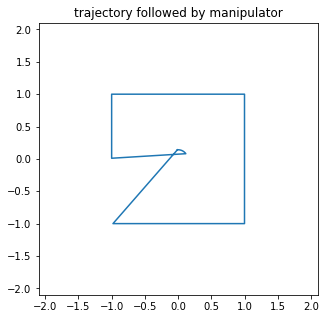

In [14]:
pos_actual=np.array(pos_actual)
plt.figure(figsize=(5,5))
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.title('trajectory followed by manipulator')
plt.plot(pos_actual[:,0],pos_actual[:,1])
#plt.plot(x1,x2)

In [15]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [16]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [17]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

In [18]:
pos_actual=[]
trajectory1(2)

[-2.0000000e+00 -2.4492936e-16]
[-2.0, 8.225462304470247e-10]
[-1.99900318 -0.0631371 ]
[-1.999003178252258, -0.06313709953245833]
[-1.99601371 -0.12621126]
[-1.9960137066628074, -0.12621126262818017]
[-1.99103457 -0.18915962]
[-1.9910345652019432, -0.1891596155925173]
[-1.98407072 -0.25191941]
[-1.984070717186158, -0.2519194101382516]
[-1.9751291  -0.31442809]
[-1.9751291043306012, -0.31442808593730515]
[-1.96421864 -0.37662333]
[-1.9642186398294261, -0.3766233329822237]
[-1.9513502  -0.43844315]
[-1.9513501994709248, -0.43844315369815223]
[-1.93653661 -0.49982592]
[-1.936536610796305, -0.49982592474336596]
[-1.91979264 -0.56071046]
[-1.919792640312918, -0.560710458436754]
[-1.90113498 -0.62103606]
[-1.9011349787746843, -0.6210360637510363]
[-1.88058222 -0.68074261]
[-1.8805822245443848, -0.680742606810895]
[-1.85815487 -0.73977057]
[-1.858154865054411, -0.739770570835731]
[-1.83387526 -0.79806112]
[-1.8338752563844443, -0.7980611154672863]
[-1.8077676  -0.85555614]
[-1.80776760097643

[1.47425838 1.3515037 ]
[1.4742583750216391, 1.3515036972493104]
[1.43085858 1.39737029]
[1.4308585768927589, 1.3973702919886444]
[1.38603247 1.44184396]
[1.3860324678166167, 1.4418439576314004]
[1.33982473 1.48488036]
[1.3398247314336023, 1.4848803618604685]
[1.29228143 1.52643661]
[1.2922814286202529, 1.5264366050521714]
[1.24344995 1.56647126]
[1.2434499515747663, 1.566471263039546]
[1.19337898 1.60494443]
[1.1933789765754326, 1.6049444284048509]
[1.14211842 1.64181775]
[1.142118415459059, 1.6418177502601465]
[1.08971937 1.67705447]
[1.0897193658677595, 1.6770544724763021]
[1.03623406 1.71061947]
[1.036234060313727, 1.7106194703222943]
[0.98171581 1.74247929]
[0.9817158141127138, 1.7424792854783129]
[0.92621897 1.77260216]
[0.9262189722381786, 1.7726021593877326]
[0.86979886 1.80095806]
[0.8697988551490297, 1.8009580649147379]
[0.8125117  1.82751874]
[0.8125117036449834, 1.827518736276027]
[0.75441462 1.8522577 ]
[0.7544146228045232, 1.852257697216753]
Position out of workspace.
[0.

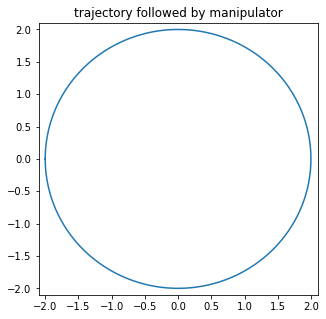

In [19]:
pos_actual=np.array(pos_actual)
plt.figure(figsize=(5,5))
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.title('trajectory followed by manipulator')
plt.plot(pos_actual[:,0],pos_actual[:,1])
#plt.plot(x1,x2)

In [20]:
pb.disconnect()